# Deep Learning 3



## Part 1. Writing a custom dataset based on Fashion-MNIST

### Part 1.1. Define a Dataset class

In [3]:
!pip install onedrivedownloader

In [4]:
from onedrivedownloader import download
import os

link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/hliu22_univ_yo_oulu_fi/EatDho3877JMlYugij_sKBkBqRz5s8hvmC1DQb0LT-W-lA?e=vkdebU'

if not os.path.exists('./data/fashion_mnist_npy'):
    print('Downloading dataset')
    download(link, filename="./fashion_mnist_npy_hw3.zip", unzip=True, unzip_path='./data/fashion_mnist_npy')

100%|██████████| 30.6M/30.6M [00:03<00:00, 9.45MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


In [5]:
# import necessary packages
import os
import torch
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms


# fashion_MNIST dataset
data_dir='./data/fashion_mnist_npy/'
train_data = np.load(os.path.join(data_dir, 'train_data.npy'))
test_data = np.load(os.path.join(data_dir, 'test_data.npy'))
train_label = np.load(os.path.join(data_dir, 'train_labels.npy'))
test_label = np.load(os.path.join(data_dir, 'test_labels.npy'))

# select 5 classes
selected_classes = [0, 1, 2, 3, 4]

# choose the data from the selected 5 classes
train_mask = np.isin(train_label, selected_classes)
train_data = train_data[train_mask]
train_label = train_label[train_mask]

test_mask = np.isin(test_label, selected_classes)
test_data = test_data[test_mask]
test_label = test_label[test_mask]

# split the training data to a new training data and validation data
class_indices = [[] for i in range(5)]
for i, v in enumerate(train_label):
    class_indices[v].append(i)

indices_all = np.random.permutation(len(class_indices[0]))
# take the first 1000 indices of indices_all
indices = indices_all[:1000]
# take the rest of the indices of indices_all
indices_rest = indices_all[1000:]

valid_indices = []
train_indices = []
for i in range(5):
    # build indices for validation set
    valid_indices.extend(np.array(class_indices[i])[indices])
    # build indices for training set
    train_indices.extend(np.array(class_indices[i])[indices_rest])

# write the custom dataset based on the dataset
class FashionMnist(Dataset):
    """Fashion Mnist dataset"""

    def __init__(self, phase='train', transform=None):

        # split the predefined training data
        if 'train' == phase:

            self.data = train_data[train_indices]
            self.labels = train_label[train_indices]

        elif 'valid' == phase:

            self.data = train_data[valid_indices]
            self.labels = train_label[valid_indices]

        elif 'test' == phase:

            self.data = test_data
            self.labels = test_label

        else:
            assert True, 'wrong phase'


        self.transform = transform

        self.label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # get image and label according to the index
        img, label = self.data[index], self.labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        return img, label


### Part 1.2. Dataset checking
First, randomly show some images in training, validation and testing data and check if the images have correct labels.<br>
Secondly, check the number of images for each class, to make sure the dataset created correctly.

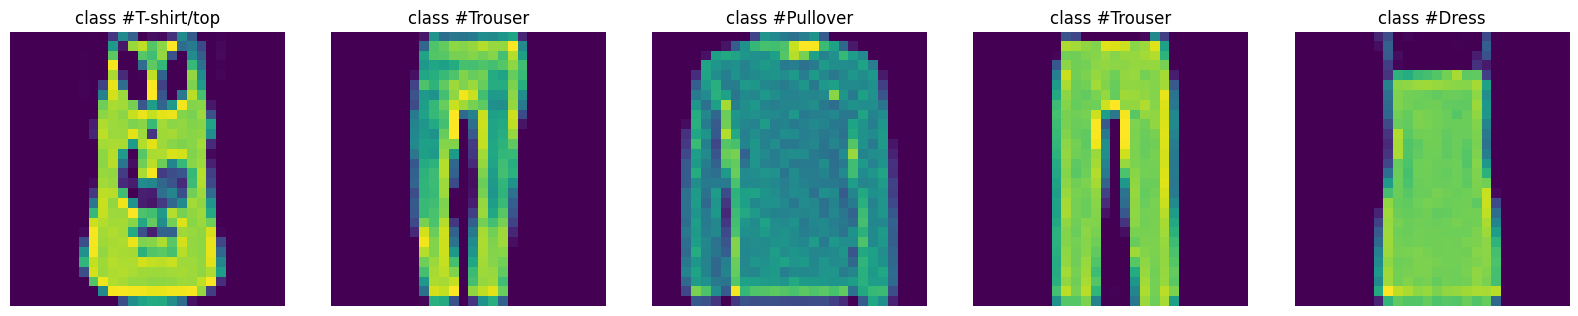

total number of training set: 25000


AttributeError: 'FashionMnist' object has no attribute 'label'

In [6]:
# checking training set
# randomly show some samples and their labels
# create a FashionMnist dataset for training, set transform to None
train_set = FashionMnist(phase='train', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_set)))
for i in range(5):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], np.sum(train_set.label==i)))

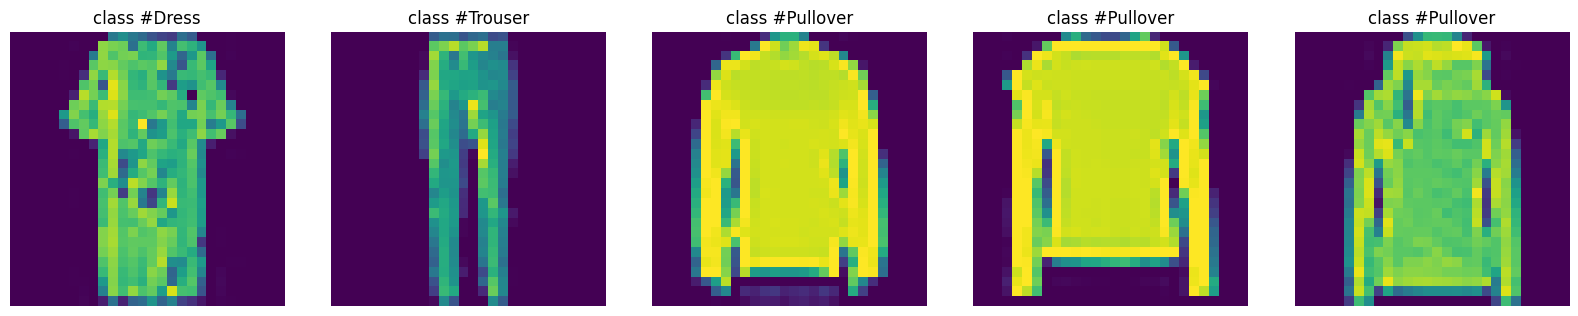

total number of validation set: 5000
number of images for class T-shirt/top: 1000
number of images for class Trouser: 1000
number of images for class Pullover: 1000
number of images for class Dress: 1000
number of images for class Coat: 1000


In [7]:
# checking validation data

valid_set = FashionMnist(phase='valid', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)  # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]
    label_name = valid_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

print('total number of validation set: {}'.format(len(valid_set)))
for i in range(5):
    print('number of images for class {}: {}'.format(valid_set.label_names[i], np.sum(valid_set.labels == i)))


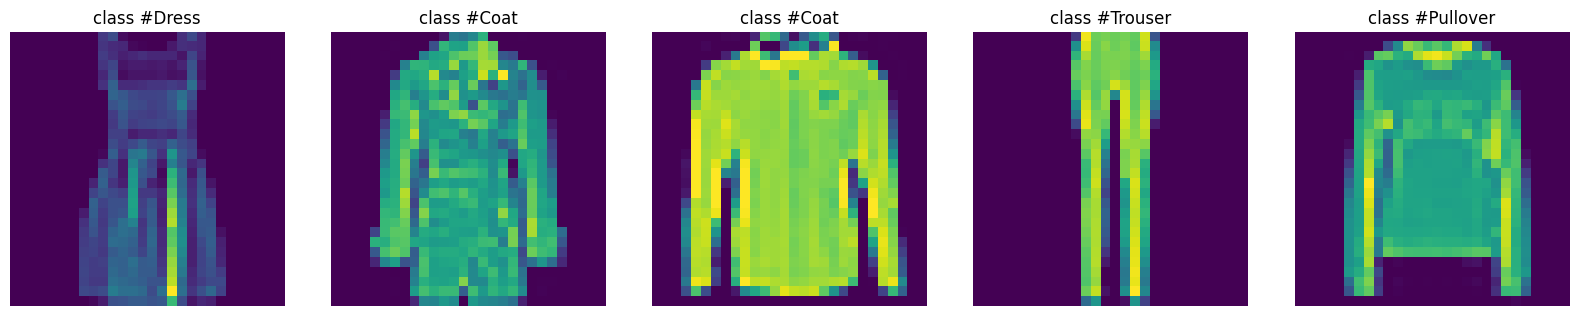

total number of test set: 5000
number of images for class T-shirt/top: 1000
number of images for class Trouser: 1000
number of images for class Pullover: 1000
number of images for class Dress: 1000
number of images for class Coat: 1000


In [8]:
# TODO: checking testing data (1 points)


test_set = FashionMnist(phase='test', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(test_set)), num_to_show, replace=False)  # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = test_set[idx[i]]
    label_name = test_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

print('total number of test set: {}'.format(len(test_set)))
for i in range(5):
    print('number of images for class {}: {}'.format(test_set.label_names[i], np.sum(test_set.labels == i)))

### Part 1.3. Iterating through the dataset with batches
Here, we add more features with the help of [DataLoader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#iterating-through-the-dataset):
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

The `DataLoader` takes as input an instance of `FashionMnist` we defined in Part 1.1. Since images in the dataset currently are all in PIL format, we have to convert them to torch.Tensor by using a transform. Actually, `transform` is often used for data augmentation, further illustrations of `transform` can be found in [https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms).

In [ ]:
# Set batch_size to 64, shuffling the training set. Number of workers here is set to 0.
data_transform = transforms.Compose([transforms.ToTensor()])

train_set = FashionMnist(phase='train', transform=data_transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)

# create test_loader and valid_loader, both with no shuffling


test_set = FashionMnist(phase='test', transform=data_transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

valid_set = FashionMnist(phase='valid', transform=data_transform)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0)

## Part 2. Build a CNN
Structure of the CNN (**Conv**: convolutional layer, **BN**: Batch Normalization layer, **Max_pool**: max pooling layer, **FC**: fully connected layer, batch_size=64):
<!--![model.png](attachment:model.png)-->
<img src=http://yty.kapsi.fi/DLcourse/ass3/CNN.png width="800">

To define your own Network, following the rule of thumb:
1. Define the layers in `__init__`.
2. Do the forward calculation in `forward`.

In [ ]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool(x)


        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(-1, 64 * 5 * 5)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)

        return x


## Part 3. Train and test CNN model
### Part 3.1. Create functions for train and evaluation
* Instantiate a network.
* When training, create an optimizer to take care of network's parameters, calculate the loss and accuracy.
* When evaluation, only need to claculate the accuracy.

In [ ]:
# instantiate a network
net = Network(num_classes=5)

# evaluation function
def eval(net, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images)
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# training function
def train(net, train_loader, valid_loader):
    loss_function = torch.nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    epoches = 10
    for epoch in range(epoches):
        net.train()
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()

            outs = net(images)
            loss = loss_function(outs, labels)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            num_images += len(labels)

        acc = correct / num_images
        acc_eval = eval(net, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return net

### Part 3.2. Train and test the network

In [ ]:
print('Please wait patiently, it may take some seconds...')


net = train(net, train_loader, valid_loader)



acc_test = eval(net, test_loader)

print('accuracy on testing data: %f' % acc_test)

Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.010000, accuracy: 0.870600, loss: 0.199153, valid accuracy: 0.906800
epoch: 1, lr: 0.010000, accuracy: 0.914880, loss: 0.202599, valid accuracy: 0.917800
epoch: 2, lr: 0.010000, accuracy: 0.925040, loss: 0.166805, valid accuracy: 0.920400
epoch: 3, lr: 0.010000, accuracy: 0.934720, loss: 0.110407, valid accuracy: 0.923600
epoch: 4, lr: 0.010000, accuracy: 0.944960, loss: 0.114993, valid accuracy: 0.922200
epoch: 5, lr: 0.010000, accuracy: 0.946800, loss: 0.046354, valid accuracy: 0.914400
epoch: 6, lr: 0.010000, accuracy: 0.949360, loss: 0.257545, valid accuracy: 0.931400
epoch: 7, lr: 0.010000, accuracy: 0.954960, loss: 0.087164, valid accuracy: 0.920200
epoch: 8, lr: 0.010000, accuracy: 0.958560, loss: 0.134557, valid accuracy: 0.934400
epoch: 9, lr: 0.010000, accuracy: 0.964640, loss: 0.031949, valid accuracy: 0.928000
accuracy on testing data: 0.927400


### Part 3.3. Modification for training


In [ ]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #new conv layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout2d(0.25)

        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(128, num_classes)

        # ...

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)   #modified the forward function accordingly
        x = self.bn3(x)
        x = self.relu4(x)
        x = self.pool3(x)

        x = self.dropout(x)

        x = x.view(-1, 64 * 5 * 5)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)

        return x















def train(net, train_loader, valid_loader):
    loss_function = torch.nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001) #weight decay 0.001

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    epoches = 10   #15 epochs
    for epoch in range(epoches):
        net.train()
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()

            outs = net(images)
            loss = loss_function(outs, labels)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            num_images += len(labels)

        acc = correct / num_images
        acc_eval = eval(net, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return net





print('Please wait patiently, it may take some seconds...')


net = train(net, train_loader, valid_loader)



acc_test = eval(net, test_loader)

print('accuracy on testing data: %f' % acc_test)




Please wait patiently, it may take some seconds...
epoch: 0, lr: 0.010000, accuracy: 0.968400, loss: 0.082014, valid accuracy: 0.918000
epoch: 1, lr: 0.010000, accuracy: 0.972520, loss: 0.096231, valid accuracy: 0.924600
epoch: 2, lr: 0.010000, accuracy: 0.972520, loss: 0.030760, valid accuracy: 0.916600
epoch: 3, lr: 0.010000, accuracy: 0.976160, loss: 0.113893, valid accuracy: 0.931200
epoch: 4, lr: 0.010000, accuracy: 0.976720, loss: 0.158516, valid accuracy: 0.924800
epoch: 5, lr: 0.010000, accuracy: 0.977200, loss: 0.131079, valid accuracy: 0.905000
epoch: 6, lr: 0.010000, accuracy: 0.979320, loss: 0.050227, valid accuracy: 0.928600
epoch: 7, lr: 0.010000, accuracy: 0.980440, loss: 0.080043, valid accuracy: 0.937600
epoch: 8, lr: 0.010000, accuracy: 0.981680, loss: 0.041586, valid accuracy: 0.934200
epoch: 9, lr: 0.010000, accuracy: 0.983440, loss: 0.013282, valid accuracy: 0.924800
accuracy on testing data: 0.922600
